# Motivation

# Business Understanding

Joe Biden won the election and he is going to be the 46th President of the United States, there are rumours about a second covid-19 wave, the covid-19 vaccines are closer than ever. Reading all those headlines and as a stock market investor a question came to my mind: How does exogenous factors influence the stocks prices?
So as an activity of the Data Science Nanodegree I am taking at Udacity and to try to combine the two things that I love the most that is data analysis and finance I decide to analyse the stock market data, using Data Science techniques to see how factors such as politics and pandemics can influence the stock market.

The goal of this notebook is to answer those 3 questions:


1.   **Does the elected President party has some influence at stocks prices ?**
2.   **How the earlier pandemics affected the stock market ?**
3.   **Is it possible to generate a simple network to predict the stock market prices ?**



# Installing the Yahoo finance library

In [127]:
!pip install yfinance

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


# Importing the needed libraries

In [128]:
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf 
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from keras.layers import Dropout, LSTM, Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [129]:
plt.rcParams['figure.figsize'] = [15, 15]

# Data Understanding

# Getting the historical S&P500 performance

In [130]:
stock_ticker = '^GSPC'

In [131]:
stock_prices_df = yf.download([stock_ticker], 
                               auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


## Let's take a look at the stock data

In [132]:
stock_prices_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,0


In [133]:
stock_prices_df.describe()

,Open,High,Low,Close,Volume
count,23358.000000,23358.000000,23358.000000,23358.000000,2.335800e+04
mean,491.534150,494.425456,488.453675,491.634806,7.753132e+08
std,735.773515,739.738420,731.446704,735.879512,1.492820e+09
min,4.400000,4.400000,4.400000,4.400000,0.000000e+00
25%,23.872500,23.872500,23.872500,23.872500,1.290000e+06
50%,99.605000,100.395000,98.814999,99.605000,1.746000e+07
75%,841.824997,851.482529,830.317474,842.589996,5.493225e+08
max,3722.389893,3726.699951,3710.870117,3722.479980,1.145623e+10


In [134]:
stock_prices_df.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

We can see that the stocks prices data frame do not have any NA data.

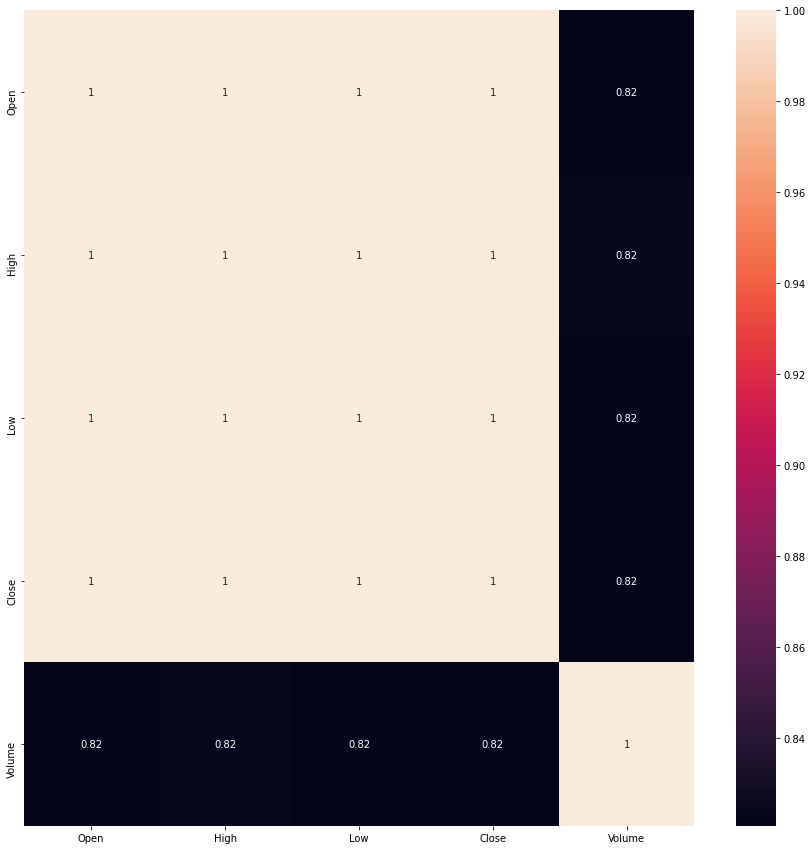

In [135]:
correlation_matrix = stock_prices_df.corr()
sns.heatmap(correlation_matrix, annot=True);

As we can see there is a high correlation between all the columns of the assets prices dataframe.

# Getting the Presidential Data

## The presidential data is from the presidential dataframe form the R package ggplot2

In [136]:
presidential_data = pd.read_csv('data/presidential.csv')

## Let's take a look at the Presidential Data

In [137]:
presidential_data

,name,start,end,party
0,Eisenhower,1953-01-20,1961-01-20,Republican
1,Kennedy,1961-01-20,1963-11-22,Democratic
2,Johnson,1963-11-22,1969-01-20,Democratic
3,Nixon,1969-01-20,1974-08-09,Republican
4,Ford,1974-08-09,1977-01-20,Republican
5,Carter,1977-01-20,1981-01-20,Democratic
6,Reagan,1981-01-20,1989-01-20,Republican
7,Bush,1989-01-20,1993-01-20,Republican
8,Clinton,1993-01-20,2001-01-20,Democratic
9,Bush,2001-01-20,2009-01-20,Republican


In [138]:
presidential_data.isna().sum()

name     0
start    0
end      0
party    0
dtype: int64

We can see that the presidential data don't have any NA data, but it is missing the Trump term and is not divided by term that is the analysis that I want to do. So let's format it.

# Q1 - Data Preparation

### Data Preparation for the question 1

# Formatting the datasets

In [139]:
# Adding the Trump term setting the end date to today
trump = pd.DataFrame({'name': 'Trump',
                      'start': '2017-01-20',
                      'end': '2020-12-02',
                      'party': 'Republican'},
                     index=[11])
presidential_data = pd.concat([presidential_data, trump])

In [140]:
# Casting the end and start presidential data columns to datetime
presidential_data['end'] = pd.to_datetime(presidential_data['end'])
presidential_data['start'] = pd.to_datetime(presidential_data['start'])

In [141]:
def split_presidential_data_terms(presidential_df,
                                  num_days_term=1461,
                                  num_years_term=4):
    '''
    Function that splits the presidential term

    Parameters
    -------
    presidential_df: Pandas Dataframe
        A pandas dataframe with the presidential data
    num_days_term: int
        The number of days of a term
    num_years_term: int
        The number of years of a term

    Return
    -------
    Pandas Dataframe
        The presidential data splitted by terms
    '''
    for index, row in presidential_df.iterrows():
        if (row['end'] - row['start']).days > num_days_term:
            second_term_start = \
              row['start'].replace(year=row['start'].year + num_years_term)
            second_term_row = pd.DataFrame({'name': f"{row['name']} II",
                                            'start': second_term_start,
                                            'end': row['end'],
                                            'party': row['party']}, index=[0])
            presidential_df.loc[index, 'name'] = f"{row['name']} I"
            presidential_df.loc[index, 'end'] = second_term_start
            presidential_df = pd.concat([presidential_df, second_term_row])

    presidential_df = presidential_df.sort_values('start')
    return presidential_df

In [142]:
presidential_data = split_presidential_data_terms(presidential_data)

In [143]:
presidential_data

,name,start,end,party
0,Eisenhower I,1953-01-20,1957-01-20,Republican
0,Eisenhower II,1957-01-20,1961-01-20,Republican
1,Kennedy,1961-01-20,1963-11-22,Democratic
2,Johnson I,1963-11-22,1967-11-22,Democratic
0,Johnson II,1967-11-22,1969-01-20,Democratic
3,Nixon I,1969-01-20,1973-01-20,Republican
0,Nixon II,1973-01-20,1974-08-09,Republican
4,Ford,1974-08-09,1977-01-20,Republican
5,Carter,1977-01-20,1981-01-20,Democratic
6,Reagan I,1981-01-20,1985-01-20,Republican


In [144]:
def get_next_work_day(df, day):
    '''
    Function that receives the stock prices dataframe a date.
    If the date is a holliday or a weekend date it is returned the next
    work day.

    Parameters
    -------
    df: Pandas Dataframe
        A pandas dataframe that has a datetime index
    day: datetime
        A datetime day date.

    Return
    -------
    Datetime
        The next day that is at the df
    '''
    while day not in df:
        day += datetime.timedelta(days=1)
    return day

## Getting the percentual change of each term

In [145]:
def get_stock_change_per_term(stock_prices_df, presidential_data):
    '''
    Get the stock change per term

    Parameters
    -------
    stock_prices_df: Pandas Dataframe
        Pandas dataframe with the assets prices
    presidential_data: Pandas Dataframe
        Pandas dataframe with the presidential data

    Return
    -------
    List
        List with the stocks results per term
    '''

    gains_list = list()
    close_prices = stock_prices_df['Close']
    for _, row in presidential_data.iterrows():
        end_date = get_next_work_day(close_prices, row['end'])
        begin_date = get_next_work_day(close_prices, row['start'])
        gain = (close_prices[end_date] -
                    close_prices[begin_date]) / close_prices[begin_date]
        gains_list.append(gain * 100)
    return gains_list

In [146]:
presidential_data['stocks_result'] = \
  get_stock_change_per_term(stock_prices_df, presidential_data)

# Plotting the results

## The stock performance in percentual at each term. The color of the bar indicates the party.

In [147]:
def formatting_axis(ax, title, xlabel, ylabel):
  '''
  Format the plot axis

  Parameters
  -------
  ax: matplotlib.axes._subplots.AxesSubplot
      The matplotlib axes
  title: String
      The plot title
  xlabel: String
      The plot x label
  ylabel: String
      The plot y label
  palette: Dict
      Dictionary that contains the colors of the bars
  '''
  ax.axes.set_title(title, fontsize = 16, weight='bold')
  ax.set_xlabel(xlabel, fontsize = 10)
  ax.set_ylabel(ylabel, fontsize = 10)

In [148]:
def democratic_republican_stocks_barplot(data,
                                         xaxis,
                                         yaxis,
                                         hue,
                                         title,
                                         xlabel,
                                         ylabel,
                                         palette={'Democratic': '#1404BD',
                                                  'Republican': '#DE0100'}):
    '''
    Plot the Democratic and Republican stocks barplot

    Parameters
    -------
    data: Pandas Dataframe
        Pandas dataframe with needed data
    xaxis: String
        The name of the column that will be used at the x axis
    yaxis: String
        The name of the column that will be used at the y axis
    hue: String
        The name of the column that will be used as the hue
    title: String
        The plot title
    xlabel: String
        The plot x label
    ylabel: String
        The plot y label
    palette: Dict
        Dictionary that contains the colors of the bars

    '''
    ax = sns.barplot(x=xaxis, y=yaxis, hue=hue, data=data, palette=palette)
    plt.setp(ax.get_xticklabels(), rotation=90)
    plt.legend(loc='upper right')
    formatting_axis(ax, title, xlabel, ylabel)
    ax;

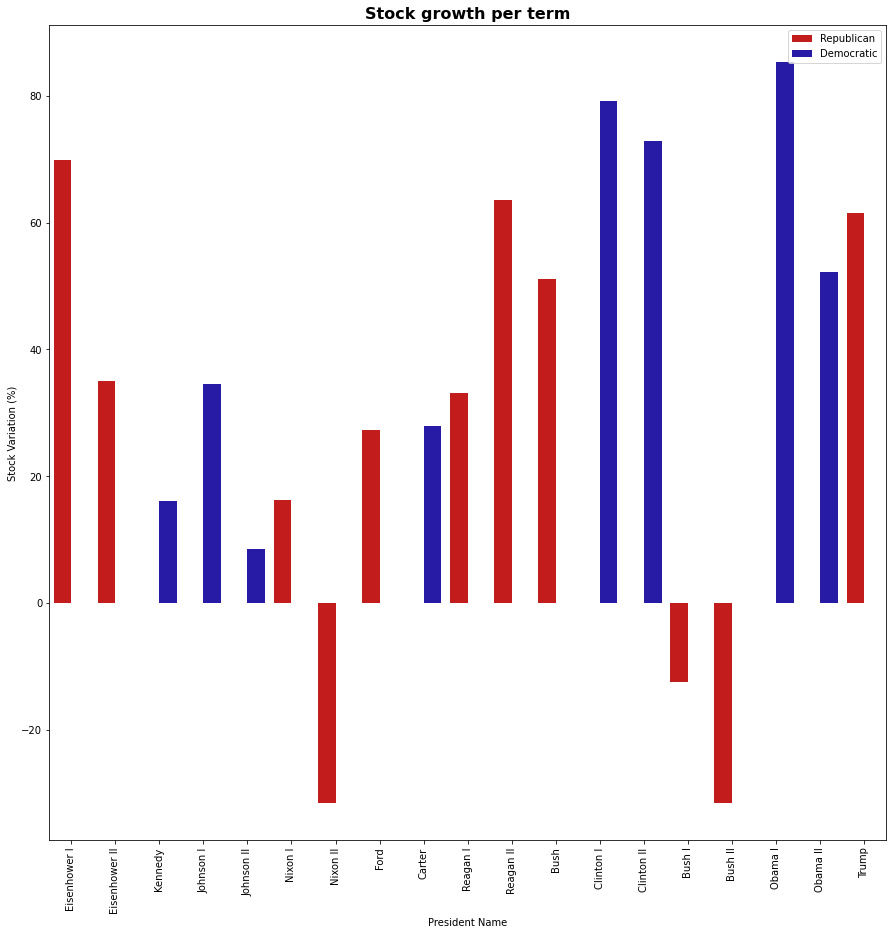

In [149]:
democratic_republican_stocks_barplot(presidential_data,
                                     'name',
                                     'stocks_result',
                                     'party',
                                     'Stock growth per term',
                                     'President Name', 'Stock Variation (%)')

Looking at this plot we can see that at all Democratics terms since 1953 the prices went up. The best term was the first one of Obama and the worse was the second of Nixon. 

In [150]:
# Getting the number of days per term
presidential_data['num_days_term'] = (
                presidential_data['end'] - presidential_data['start']).\
                astype('timedelta64[D]')

In [151]:
presidential_data[['name', 'num_days_term']]

,name,num_days_term
0,Eisenhower I,1461.0
0,Eisenhower II,1461.0
1,Kennedy,1036.0
2,Johnson I,1461.0
0,Johnson II,425.0
3,Nixon I,1461.0
0,Nixon II,566.0
4,Ford,895.0
5,Carter,1461.0
6,Reagan I,1461.0


Looking at the dataframe above we can see some ouliers, such as the Kennedy term and the Ford term. So Now we want to see how the stock market performed per year at each term.

## Getting the stock performance in percentual at each term per year

In [152]:
# Getting the stock growth per year per legislation
days_in_year = 365.25
presidential_data['growth_per_year'] = presidential_data['stocks_result'] / (
                presidential_data['num_days_term'] / days_in_year)

In [153]:
presidential_data

,name,start,end,party,stocks_result,num_days_term,growth_per_year
0,Eisenhower I,1953-01-20,1957-01-20,Republican,69.854639,1461.0,17.463660
0,Eisenhower II,1957-01-20,1961-01-20,Republican,35.045038,1461.0,8.761260
1,Kennedy,1961-01-20,1963-11-22,Democratic,16.094065,1036.0,5.674090
2,Johnson I,1963-11-22,1967-11-22,Democratic,34.535269,1461.0,8.633817
0,Johnson II,1967-11-22,1969-01-20,Democratic,8.585158,425.0,7.378186
3,Nixon I,1969-01-20,1973-01-20,Republican,16.245448,1461.0,4.061362
0,Nixon II,1973-01-20,1974-08-09,Republican,-31.596311,566.0,-20.389669
4,Ford,1974-08-09,1977-01-20,Republican,27.343557,895.0,11.158921
5,Carter,1977-01-20,1981-01-20,Democratic,27.852765,1461.0,6.963191
6,Reagan I,1981-01-20,1985-01-20,Republican,33.102927,1461.0,8.275732


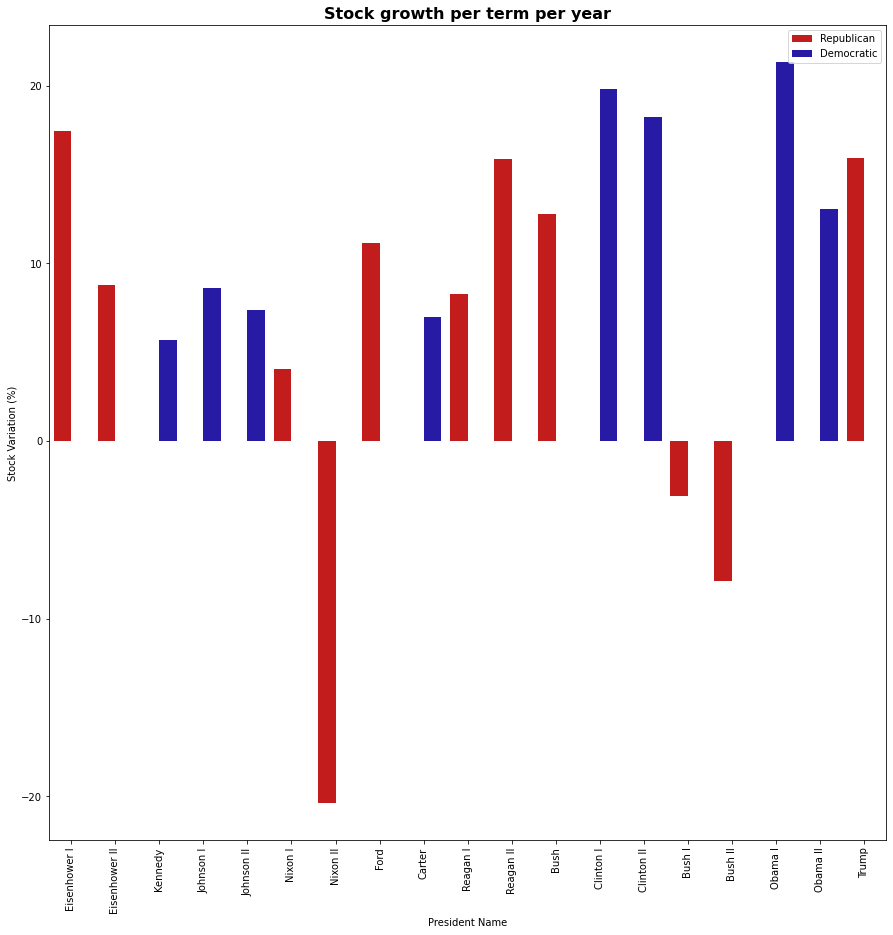

In [154]:
democratic_republican_stocks_barplot(presidential_data,
                                     'name',
                                     'growth_per_year',
                                     'party',
                                     'Stock growth per term per year',
                                     'President Name',
                                     'Stock Variation (%)')

Looking at this plot we can see that at the best term getting the performace per year was also the first one of Obama and the worse was also the second of Nixon. 

## Getting the average performance per year per party

### Average inflation of the period [inflation calcultor](https://www.usinflationcalculator.com/inflation/historical-inflation-rates/)

In [155]:
inflation = 3.44

In [156]:
presidential_data_grouped = presidential_data.groupby(['party']).agg(
                {'stocks_result': 'sum', 'num_days_term': 'sum'}).reset_index()
presidential_data_grouped['term_time_year'] = \
    presidential_data_grouped['num_days_term'] / days_in_year
presidential_data_grouped['stock_grow_per_year'] = \
    presidential_data_grouped['stocks_result'] / \
    presidential_data_grouped['term_time_year']
presidential_data_grouped['stock_grow_per_year_inflation_adjusted'] = (
    ((100 + presidential_data_grouped['stock_grow_per_year']) / \
     (100 + inflation)) - 1) * 100

## Ploting the average gain per year for each party

In [157]:
presidential_data_grouped

,party,stocks_result,num_days_term,term_time_year,stock_grow_per_year,stock_grow_per_year_inflation_adjusted
0,Democratic,376.724710,10227.0,28.000000,13.454454,9.681413
1,Republican,282.334175,14561.0,39.865845,7.082107,3.520985


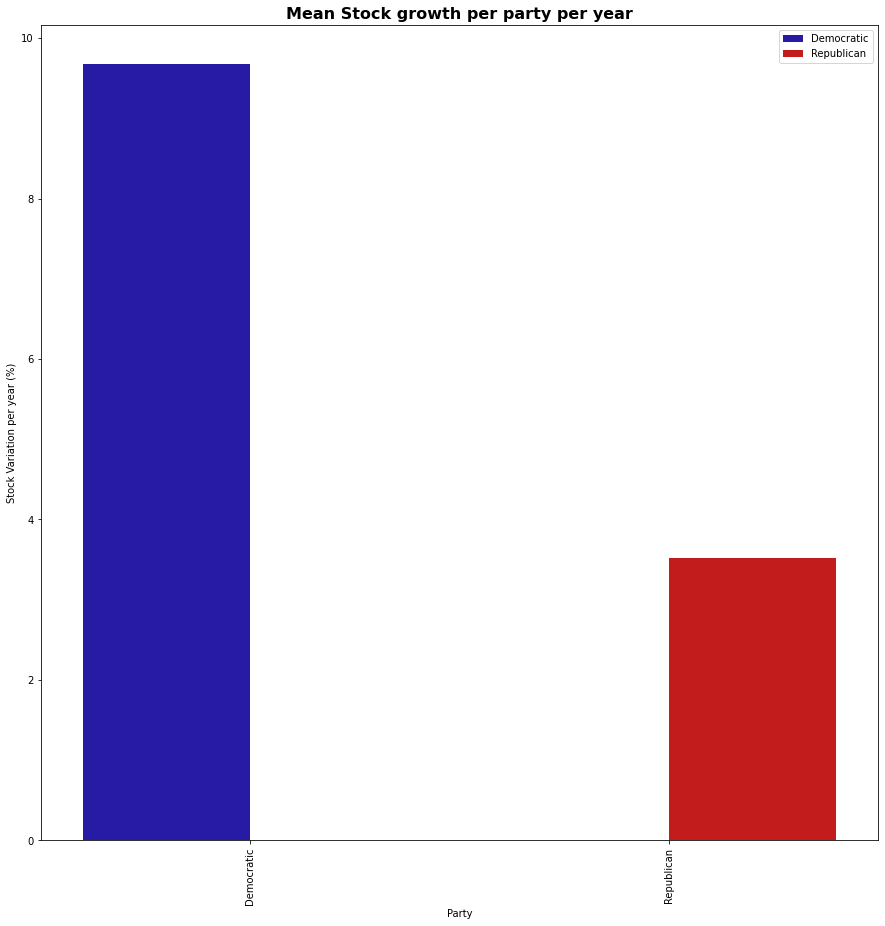

In [158]:
democratic_republican_stocks_barplot(presidential_data_grouped,
                                     'party',
                                     'stock_grow_per_year_inflation_adjusted',
                                     'party',
                                     'Mean Stock growth per party per year',
                                     'Party',
                                     'Stock Variation per year (%)')

# Q1 - Evaluate the Results

### Evaluation for the question 1

### Does the elected President party has some influence at stocks prices ?

So looking at the results above and disregarding all other factors that also influence the assets prices and considering only the President party it is more probable that the stock market will grow during the government of Joe Biden.

# Q2 - Data Preparation

### Data Preparation for the question 2

In [159]:
def add_annotation(ax, name, data, date, i=0, shrink=0.05,
                   x_padding=0.4, y_padding=0.45):
    '''
    Add an arrow annotation at the plot.

    Parameters
    -------
    ax: matplotlib.axes._subplots.AxesSubplot
        The matplotlib axes
    name: String
        The annotation name
    data: Pandas Dataframe
        Dataset for plotting
    date: datetime.datetime
        The date where should the annotation be written to
    i: int
        The index of the annotation
    shrink: float
        Fraction of total length to shrink from both ends
    x_padding: float
        X text padding
    y_padding: float
        Y text padding
    '''
    ax.annotate(name,
                xy=(mdates.date2num(date), data['Close'][date]),
                xycoords='data',
                xytext=(i/10 + x_padding, i/10 + y_padding),
                textcoords='axes fraction',
                arrowprops=dict(facecolor='black', shrink=shrink),
                horizontalalignment='right', verticalalignment='top',
                weight='bold')

# Plotting the stock price performace at the pandemics date

## Getting the pandemics data

In [160]:
asian_flu_date = datetime.datetime(1957, 2, 11)
asian_flu = 'Asian Flu'
aids_date = datetime.datetime(1981, 6, 10)
aids = 'AIDS'
swine_flu_date = datetime.datetime(2009, 4, 13)
swine_flu = 'Swine Flu'
ebola_date = datetime.datetime(2013, 12, 26)
ebola = 'Ebola'
covid_date = datetime.datetime(2019, 12, 3)
covid = 'Covid-19'
pandemic_dates = [asian_flu_date, aids_date, 
                  swine_flu_date, ebola_date, covid_date]
pandemic_names = [asian_flu, aids, swine_flu, ebola, covid]

## Plotting the annotations

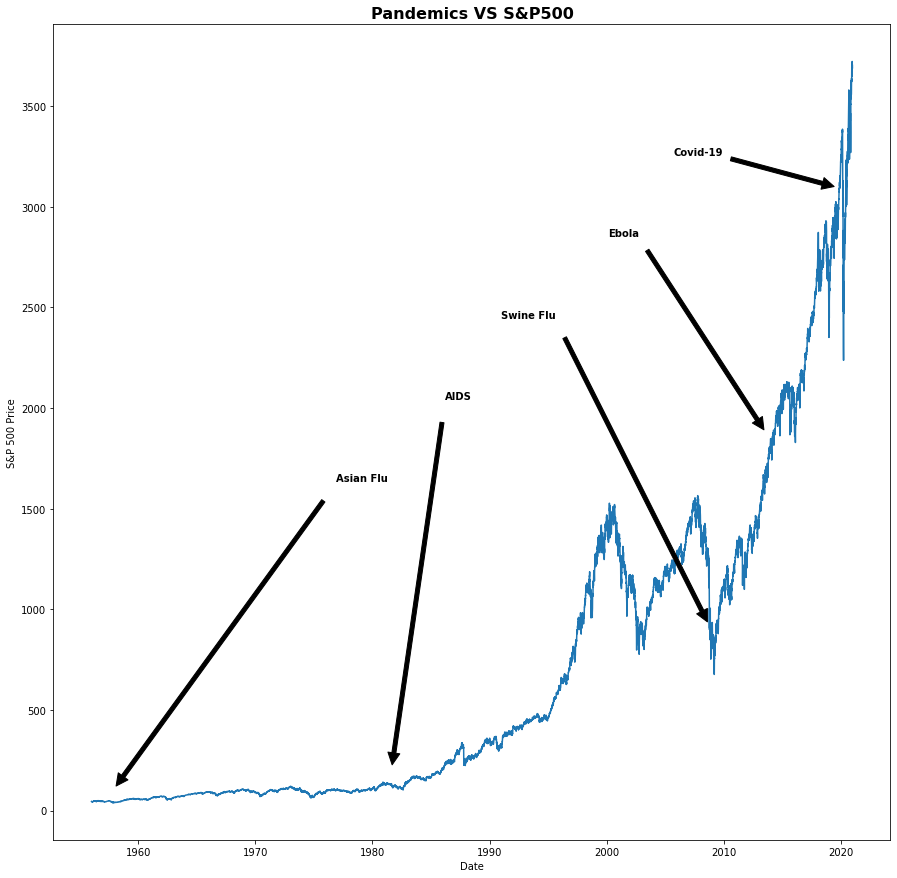

In [161]:
fig, ax = plt.subplots(figsize=(15, 15))

# The first pandemic started at 1957
# So I chose to trace asset prices starting at 1956
ax.plot(stock_prices_df["1956-01-01":].index,
        stock_prices_df["1956-01-01":]['Close'])
for i, name in enumerate(pandemic_names):
    add_annotation(ax, name, stock_prices_df, pandemic_dates[i], i)

formatting_axis(ax, 'Pandemics VS S&P500', 'Date', 'S&P 500 Price')
plt.show();

With this visualization we can not know if the pandemics had an impact at the stock market prices.

## Plotting the stock performance at a range of one year before and after each one of the pandemics

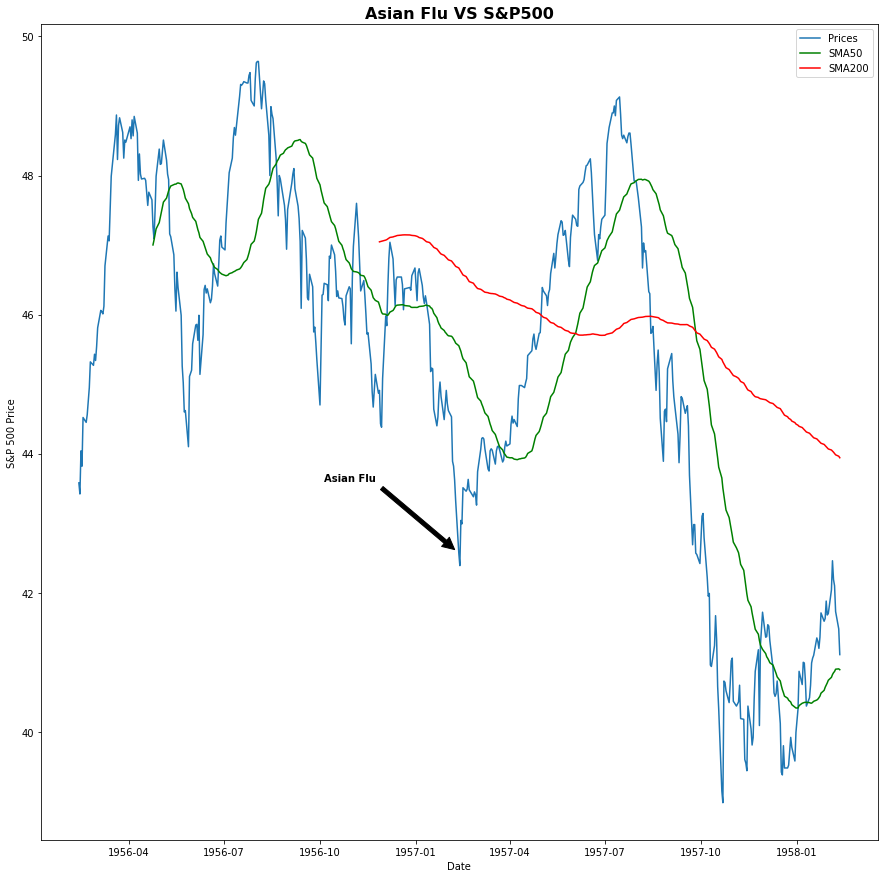

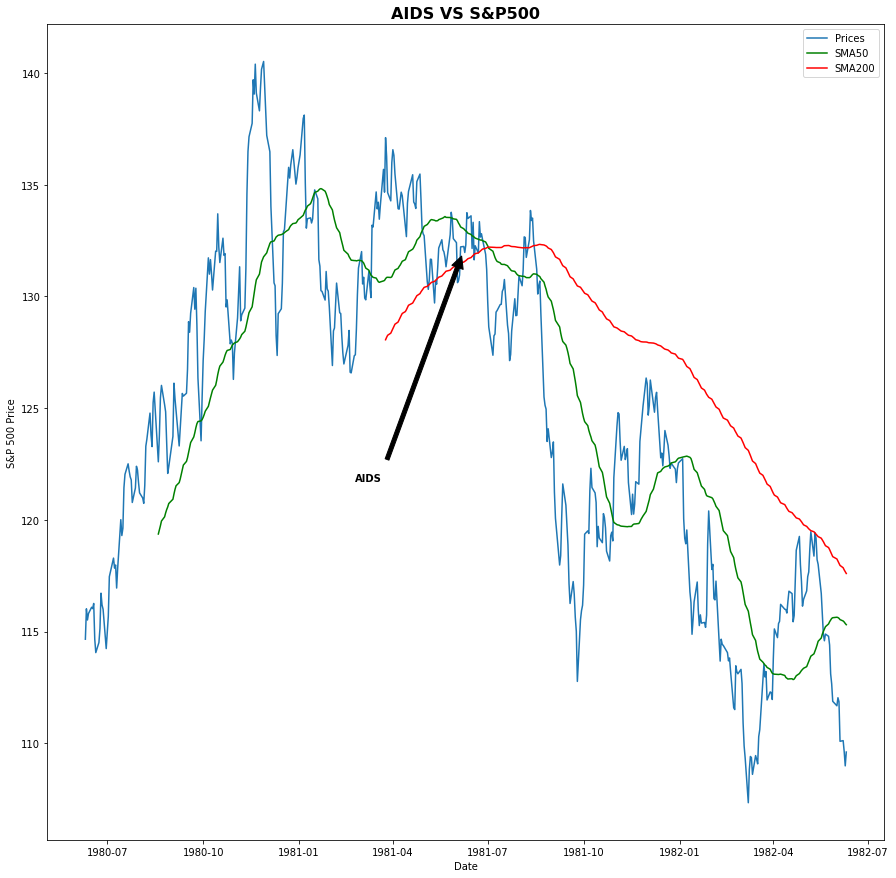

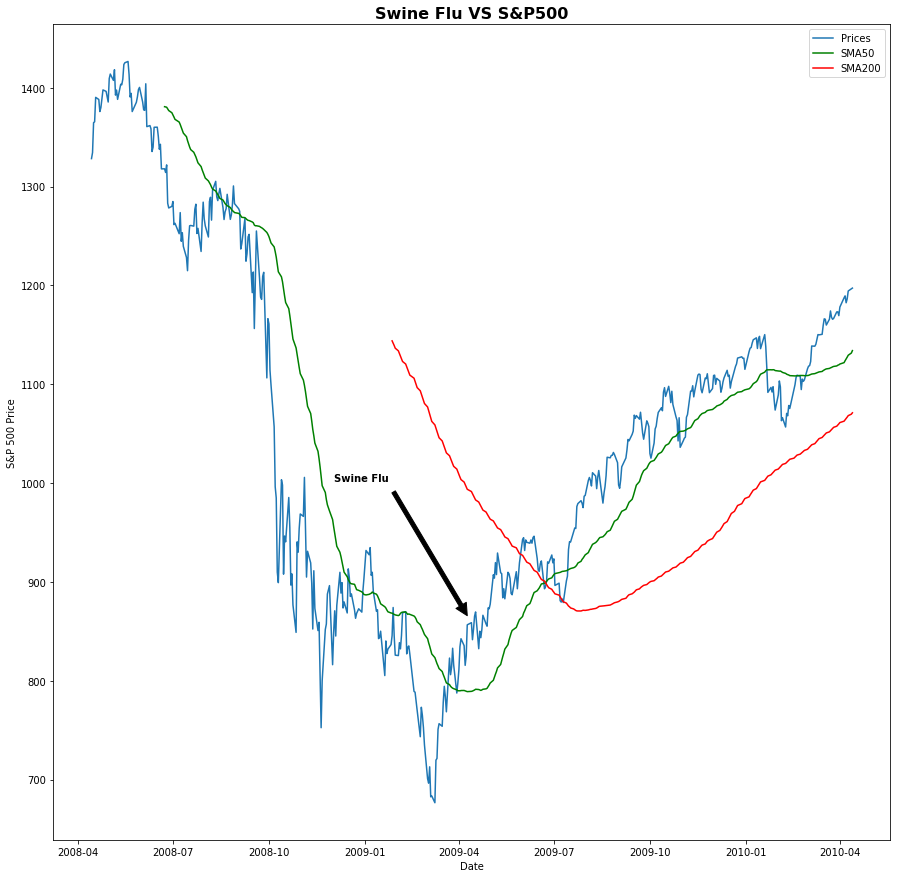

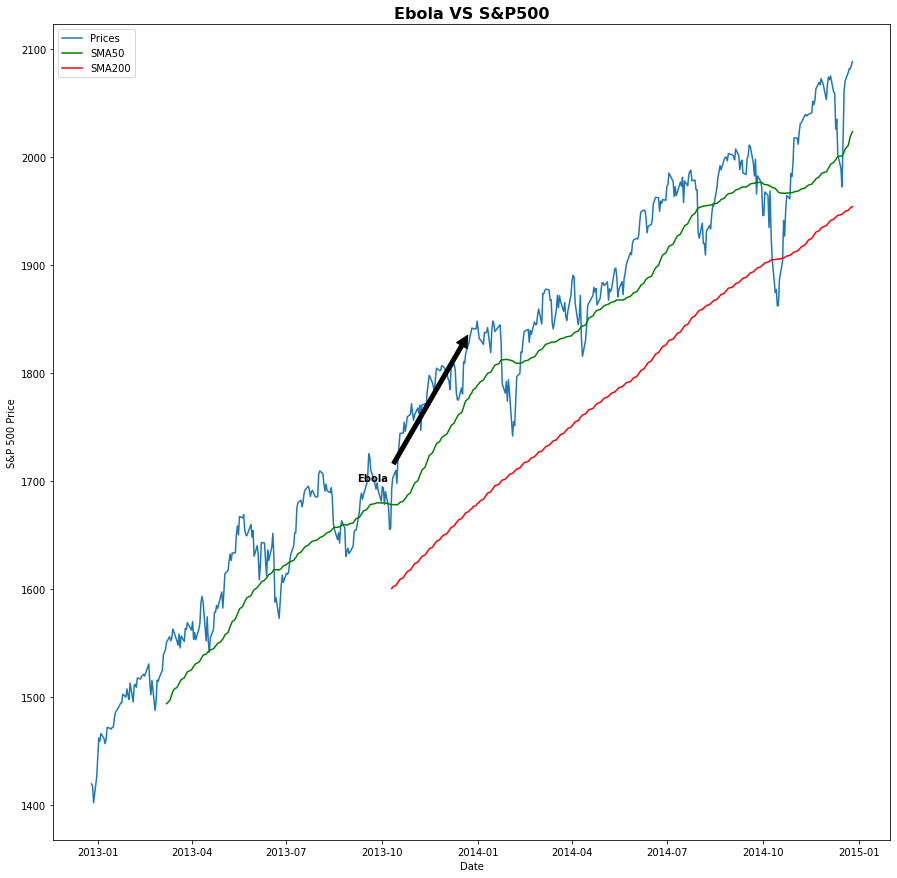

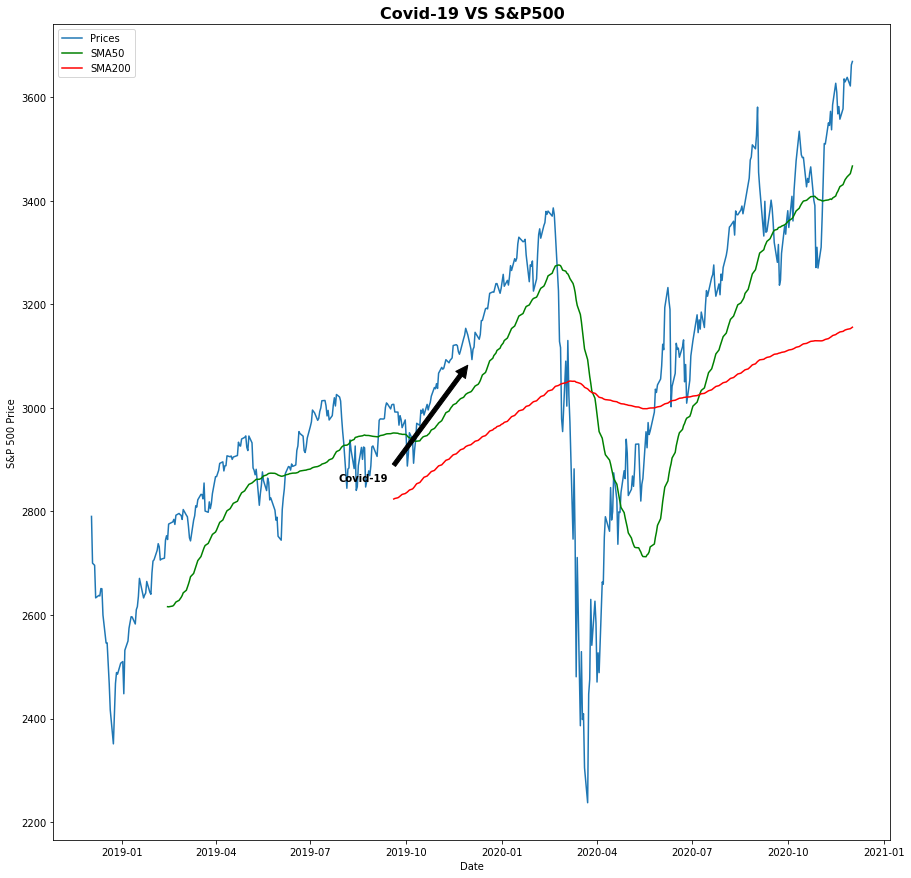

In [162]:
for i, date in enumerate(pandemic_dates):
    fig, ax = plt.subplots(figsize=(15, 15))

    # Getting the range one year before the pandemic until one year after the pandemic
    stock_prices_df_pandemic = \
        stock_prices_df[
                         (date - datetime.timedelta(days=365)):
                         (date + datetime.timedelta(days=365))]
    line, = \
        ax.plot(stock_prices_df_pandemic.index,
                stock_prices_df_pandemic['Close'],
                label='Prices')
    # Getting the 50-days and 200-days moving average
    moving_avg_50 = stock_prices_df_pandemic['Close'].rolling(50).mean()
    moving_avg_200 = stock_prices_df_pandemic['Close'].rolling(200).mean()
    ax.plot(moving_avg_50, color='green', label="SMA50")
    ax.plot(moving_avg_200, color='red', label="SMA200")
    # Adding the annotations
    add_annotation(ax, pandemic_names[i], stock_prices_df_pandemic, date)
    # Formatting the graph
    title = '{} VS S&P500'.format(pandemic_names[i])
    formatting_axis(ax, title, 'Date', 'S&P 500 Price')
    ax.legend()

# Q2 - Evaluate the Results

### Evaluation for the question 2

### How the earlier pandemics affected the stock market ?

Thus, it seems like we can not know the effects on a pandemic on the short-term. But one thing that has shown valid, it is that the S&P 500 for the long run has a growth tendency.

# Q3 - Data Preparation

### Data Preparation for the question 3

# Formatting the data to use a LSTM



In [163]:
# Getting the close prices
close_prices = stock_prices_df[['Close']]

In [164]:
# Scalling init
scaler = MinMaxScaler()

In [165]:
# Scalling the close prices data
close_prices = scaler.fit_transform(close_prices)

In [166]:

def spliting_feature_target(prices_list, previous_n):
    '''
    Splits a list into features and target, using a format
    that can be used at a LSTM

    Parameters
    -------
    prices_list: List
        List with the stocks prices
    previous_n: Int
        The number of itens that compose each input of
        the features list

    Returns
    -------
    Tuple
        Np array of the features
        Np array of the target
    '''
    features_list = list()
    target_list = list()
    for i in range(len(prices_list) - previous_n - 1):
        features_list.append(prices_list[i: i + previous_n])
        target_list.append(prices_list[i + previous_n])

    return np.array(features_list), np.array(target_list)

## Spliting in test, train and validation data

I chose 64% to train ratio, 16% for validation ratio and 20% as the test ratio

In [167]:
previous_n = 10

In [169]:
def get_train_test_val_datasets(data,
                                previous_n,
                                train_ratio=0.64,
                                test_ratio=0.2):
    '''
    Splits a numpy array into train, validation and
    test dataset.

    Parameters
    -------
    data: Np.array
        The array with all the data
    previous_n: Int
        The number of itens that compose each input of
        the features list
    train_ratio: Float
        The train ratio
    test_ratio: Float
        The test ratio

    Returns
    -------
    Tuple
        Np array with the train data
        Np array with the validation data
        Np array with the test data
    '''
    data_lenght = len(data)
    val_ratio = 1 - (train_ratio + test_ratio)
    train_size = int(train_ratio * data_lenght)
    val_size = int(val_ratio * data_lenght) + train_size

    return data[:train_size], \
        data[train_size:val_size], \
        data[val_size:]

In [170]:
train_dataset, val_dataset, test_dataset = \
    get_train_test_val_datasets(close_prices, previous_n)

In [171]:
X_train, y_train = spliting_feature_target(train_dataset, previous_n)
X_test, y_test = spliting_feature_target(test_dataset, previous_n)
X_val, y_val = spliting_feature_target(val_dataset, previous_n)

## Reshaping the data, as we can see at the [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/) the input shape is a A 3D tensor with shape [batch, timesteps, feature].

In [172]:
def format_input_data_LSTM(data, previous_n, num_features):
    '''
    Reshape a np.array to the format accepted by a LSTM, that is
    (batch, timesteps, feature)

    Parameters
    -------
    data: Np.Array
        Np.array with the data to reshape
    previous_n: Int
        The number of itens that compose each input of
        the features list
    num_features: Int
        The number of features

    Returns
    -------
    Np.Array
        Reshaped np array.
    '''
    return np.reshape(data, (len(data), previous_n, num_features))

In [173]:
X_train = format_input_data_LSTM(X_train, previous_n, 1)
X_test = format_input_data_LSTM(X_test, previous_n, 1)
X_val = format_input_data_LSTM(X_val, previous_n, 1)

# Data Modeling

## Building and running the LSTM

In [174]:
def build_LSTM(previous_n):
    '''
    Build a LSTM neural network

    Parameters
    -------
    previous_n: Int
        The number of itens that compose each input of
        the features list

    Returns
    -------
    Keras Model
        A LSTM neural network
    '''
    model = Sequential()
    model.add(LSTM(previous_n, input_shape=(previous_n, 1)))
    model.add(Dropout(0.3))
    model.add(Dense(32))
    model.add(Dropout(0.5))
    model.add(Dense(16))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model


Training the model with 60 epochs.

In [175]:
# Init a EarlyStopping Callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

In [176]:
epochs = 1000

In [177]:
model = build_LSTM(previous_n)
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callback])

Epoch 1/1000
467/467 [==============================] - 5s 12ms/step - loss: 6.0938e-05 - val_loss: 7.3087e-04
Epoch 2/1000
467/467 [==============================] - 5s 11ms/step - loss: 3.7870e-05 - val_loss: 9.9550e-04
Epoch 3/1000
467/467 [==============================] - 5s 10ms/step - loss: 3.2908e-05 - val_loss: 1.4067e-04
Epoch 4/1000
467/467 [==============================] - 5s 10ms/step - loss: 3.1069e-05 - val_loss: 3.1749e-04
Epoch 5/1000
467/467 [==============================] - 5s 10ms/step - loss: 2.9371e-05 - val_loss: 7.4353e-05
Epoch 6/1000
467/467 [==============================] - 4s 9ms/step - loss: 2.8092e-05 - val_loss: 5.7534e-04
Epoch 7/1000
467/467 [==============================] - 5s 10ms/step - loss: 2.7792e-05 - val_loss: 1.5047e-04
Epoch 8/1000
467/467 [==============================] - 5s 10ms/step - loss: 2.7434e-05 - val_loss: 5.7740e-05
Epoch 9/1000
467/467 [==============================] - 5s 10ms/step - loss: 2.6673e-05 - val_loss: 1.8529e-04
Ep

In [178]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

## Getting the validation metrics

In [179]:
def two_lines_plot(data1, data2, label1, label2):
    '''
    Plot two lines at the same plot

    Parameters
    -------
    data1: np.Array
        Data for the first line
    data2: np.Array
        Data for the second line
    label1: string
        Label for the first legend
    label2: string
        Label for the second legend

    Returns
    -------
        matplotlib.axes._subplots.AxesSubplot
    '''
    _, ax = plt.subplots(figsize=(15, 15))
    ax.plot(data1, label=label1)
    ax.plot(data2, label=label2)
    ax.legend()

    return ax

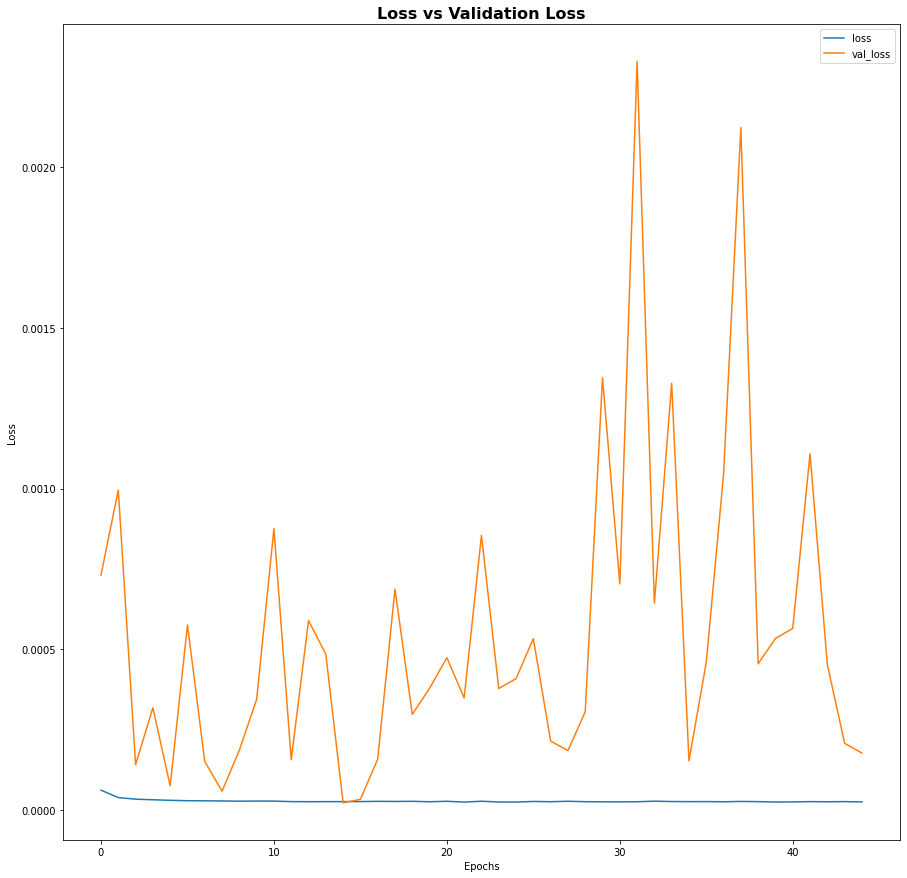

In [180]:
ax = \
  two_lines_plot(history.history['loss'],
                 history.history['val_loss'],
                 'loss',
                 'val_loss')
formatting_axis(ax, "Loss vs Validation Loss", "Epochs", "Loss")
plt.show()

In [181]:
val_predictions = model.predict(X_val)

In [182]:
y_val = scaler.inverse_transform(y_val)

In [183]:
val_predictions = scaler.inverse_transform(val_predictions)

In [184]:
rmse = mean_squared_error(y_val, val_predictions, squared=False)
mae = mean_absolute_error(y_val, val_predictions)

In [185]:
print(f'Root Mean Squared Error = {rmse}')
print(f'Mean Absolute Error = {mae}')

Root Mean Squared Error = 49.39104183307359
Mean Absolute Error = 38.95238132446092


### Plotting the Validation Predictions VS the Real values

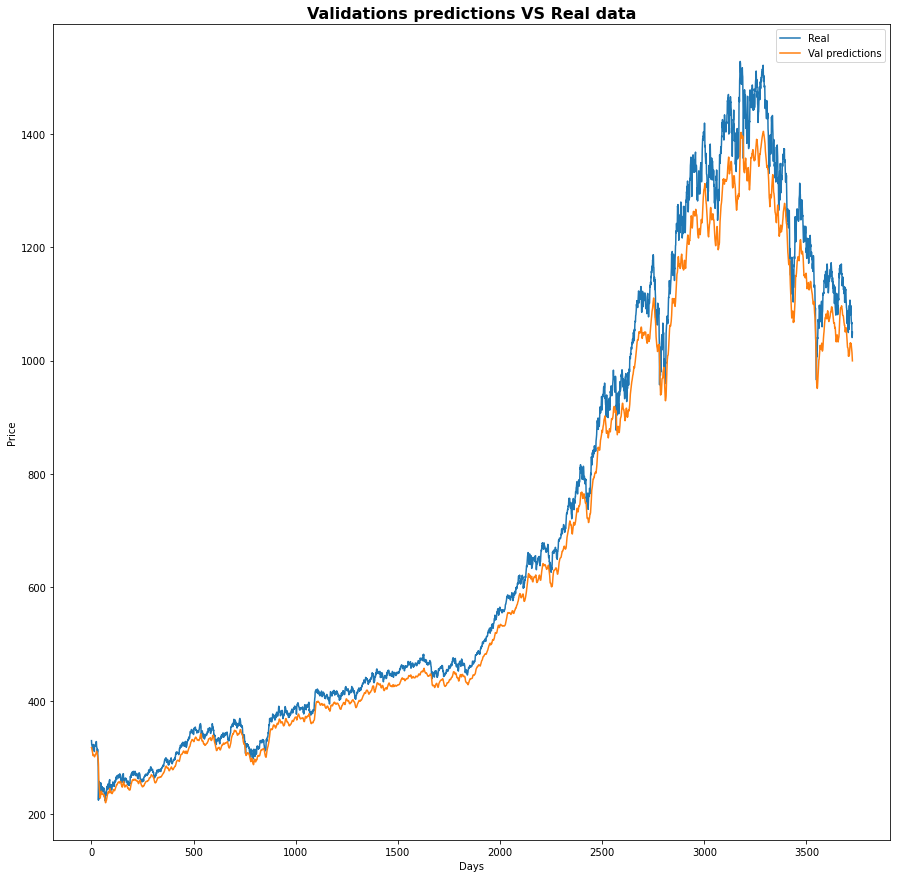

In [186]:
ax = \
  two_lines_plot(y_val,
                 val_predictions,
                 'Real',
                 'Val predictions')
formatting_axis(ax, "Validations predictions VS Real data", "Days", "Price")
plt.show();

As we can see, the predictions start well and get worse over time

## Getting the test metrics

In [187]:
test_predictions = model.predict(X_test)

In [188]:
y_test = scaler.inverse_transform(y_test)

In [189]:
test_predictions = scaler.inverse_transform(test_predictions)

In [190]:
rmse = mean_squared_error(y_test, test_predictions, squared=False)
mae = mean_absolute_error(y_test, test_predictions)

In [191]:
print(f'Root Mean Squared Error = {rmse}')
print(f'Mean Absolute Error = {mae}')

Root Mean Squared Error = 263.2501510900622
Mean Absolute Error = 188.98202655418214


### Plotting the Test Predictions VS the Real values

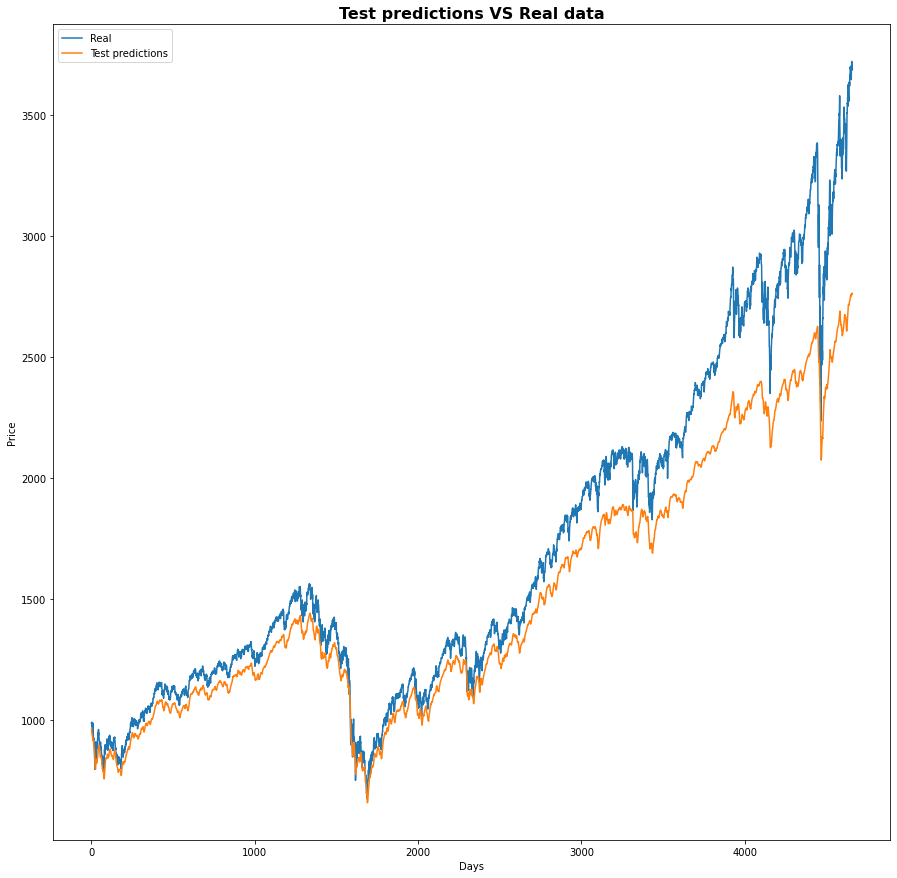

In [192]:
ax = \
  two_lines_plot(y_test,
                 test_predictions,
                 'Real',
                 'Test predictions')
formatting_axis(ax, "Validations predictions VS Real data", "Days", "Price")
formatting_axis(ax, "Test predictions VS Real data", "Days", "Price")
plt.show();

As we can see, the predictions start well also, but they are really bad at the end

# Q3 - Evaluate the Results

### Evaluation for the question 3

### Is it possible to generate a simple network to predict the stock market prices ?

So on average the model is wrong by $ 263 on forecasts and as we can see at the plot, the predictions are not close to the real price.
Thus, this model was not capable of realizing good predictions.